In [1]:
#Installations
!pip install torch==2.5.0 #downgrade torch for compatability purposes
!pip install torch_geometric
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install pyarrow pandas awkward
!pip install matplotlib tensorboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found e

In [2]:
# mount google drive to load files directly from there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# if you want to import Python files, add the correct Google Drive directory to your Pythonpath
import sys
sys.path.append('/content/drive/My Drive/AdvDL/GNN_prediction')

In [4]:
# Download the data from huggingface (https://huggingface.co/datasets/simbaswe/galah4/tree/main)
# and upload it to your google drive. Then, specify this directory here
DATA_PATH = '/content/drive/My Drive/AdvDL/GNN_prediction/'

In [5]:
# --- General-purpose utilities ---
import os
import time
import sys
import io
from datetime import datetime
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt

# --- PyTorch Core ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# --- PyTorch Geometric ---
from torch_geometric.data import Data, Batch
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool

# --- TensorBoard (optional) ---
from torch.utils.tensorboard import SummaryWriter


In [6]:
# Load the dataset
train_dataset = ak.from_parquet(os.path.join(DATA_PATH, "train.pq"))
val_dataset = ak.from_parquet(os.path.join(DATA_PATH, "val.pq"))
test_dataset = ak.from_parquet(os.path.join(DATA_PATH, "test.pq"))

In [7]:
#Dataset inspection:
print(f"The training dataset contains {len(train_dataset)} events.")
print(f"The validation dataset contains {len(val_dataset)} events.")
print(f"The test dataset contains {len(test_dataset)} events.")
print(f"The training dataset has the following columns: {train_dataset.fields}")
print(f"The validation dataset has the following columns: {val_dataset.fields}")
print(f"The test dataset has the following columns: {test_dataset.fields}")
# print the first event of the training dataset
print(f"The first event of the training dataset is: {train_dataset[0]}")

The training dataset contains 10001 events.
The validation dataset contains 10001 events.
The test dataset contains 10001 events.
The training dataset has the following columns: ['xpos', 'ypos', 'data', 'energy', 'xdir', 'ydir']
The validation dataset has the following columns: ['xpos', 'ypos', 'data', 'energy', 'xdir', 'ydir']
The test dataset has the following columns: ['xpos', 'ypos', 'data', 'energy', 'xdir', 'ydir']
The first event of the training dataset is: {xpos: 3.94, ypos: -7.12, data: [[14.5, ...], ...], energy: 10, xdir: 1, ...}


In [8]:
# The data can be accessed by using the 'data' key.
# The data is a 3D array with the first dimension being the number of events,
# the second dimension being the the three features (time, x, y)
# the third dimension being the number of hits,
#Data: (num_events, (time, x, y), number of hits)
print(f"The first event of the training dataset has {len(train_dataset['data'][0][0])} hits, i.e., detected photons.")
print(f"The second event of the training dataset has {len(train_dataset['data'][1][0])} hits, i.e., detected photons.")
# Let's loop over all hits and print the time, x, and y coordinates of the first event.
for i in range(len(train_dataset['data'][0, 0])):
    print(f"Hit {i}: time = {train_dataset['data'][0,0,i]}, x = {train_dataset['data'][0,1, i]}, y = {train_dataset['data'][0,2,i]}")
# To get all hit times of the first event, you can use the following code:
print(f"The first event of the training dataset has the following hit times: {train_dataset['data'][0, 0]}")
print(f"The first event of the training dataset has the following hit x positions: {train_dataset['data'][0, 1]}")
print(f"The first event of the training dataset has the following hit y positions: {train_dataset['data'][0, 2]}")
##NOTE: x and y tell you which detector module (in the 4×4 array) detected each photon.
#Each (x, y) pair corresponds to a physical location of a module, These are the GNN input features.
#On the other hand, xpos, ypos (outside of "data") but also bound to an "event" are the true coordinates of the neutrino interaction — the target you're predicting.
#Each event has one neutrino interaction. The light spreads out and hits many detectors, but the interaction itself happened at a single point.
#That single point is what we are trying to predict with out GNN, xpos, ypos are used as labesl in supervised learning.




The first event of the training dataset has 12 hits, i.e., detected photons.
The second event of the training dataset has 21 hits, i.e., detected photons.
Hit 0: time = 14.490445777588475, x = -2.5, y = -2.5
Hit 1: time = 17.1297022177257, x = -2.5, y = -2.5
Hit 2: time = 8.996675814194964, x = 2.5, y = -2.5
Hit 3: time = 12.021784213609394, x = 2.5, y = -2.5
Hit 4: time = 12.923289636173713, x = 2.5, y = -2.5
Hit 5: time = 25.1516276582378, x = -2.5, y = -0.8333333333333333
Hit 6: time = 15.286326473533162, x = 0.8333333333333335, y = -0.8333333333333333
Hit 7: time = 15.14788039212255, x = 2.5, y = -0.8333333333333333
Hit 8: time = 16.565114961505415, x = -0.8333333333333333, y = 0.8333333333333335
Hit 9: time = 19.47621700139486, x = -0.8333333333333333, y = 0.8333333333333335
Hit 10: time = 16.912010076540938, x = 2.5, y = 2.5
Hit 11: time = 19.57845737402364, x = 2.5, y = 2.5
The first event of the training dataset has the following hit times: [14.5, 17.1, 9, 12, 12.9, 25.2, 15.3,

In [9]:
# Step 3: Normalization helpers

def compute_global_mean_std(awk_array, idx):
    """
    Extracts all values at index `idx` across events and returns mean & std.
    idx = 0 for time, 1 for x, 2 for y
    """
    flat = ak.flatten(awk_array["data"][:, idx, :])
    return np.mean(flat), np.std(flat)

# Compute stats from training set only
time_mean, time_std = compute_global_mean_std(train_dataset, 0)
x_mean, x_std = compute_global_mean_std(train_dataset, 1)
y_mean, y_std = compute_global_mean_std(train_dataset, 2)

# Print for verification
print(f"time_mean: {time_mean:.2f} and time_std: {time_std:.2f} of training data")
print(f"x_mean: {x_mean:.2f} and x_std: {x_std:.2f} of training data")
print(f"y_mean: {y_mean:.2f} and y_std: {y_std:.2f} of training data")


time_mean: 12.49 and time_std: 5.79 of training data
x_mean: 0.10 and x_std: 1.85 of training data
y_mean: 0.00 and y_std: 1.85 of training data


In [10]:
def normalize_dataset(dataset, time_mean, time_std, x_mean, x_std, y_mean, y_std):
    # Extract time, x, y components from the data
    times = dataset["data"][:, 0:1, :]
    x = dataset["data"][:, 1:2, :]
    y = dataset["data"][:, 2:3, :]

    # Normalize
    norm_times = (times - time_mean) / time_std
    norm_x = (x - x_mean) / x_std
    norm_y = (y - y_mean) / y_std

    # Reassemble the normalized data
    dataset["data"] = ak.concatenate([norm_times, norm_x, norm_y], axis=1)

    # Normalize labels (can be done in-place)
    dataset["xpos"] = (dataset["xpos"] - x_mean) / x_std
    dataset["ypos"] = (dataset["ypos"] - y_mean) / y_std

    return dataset

train_dataset = normalize_dataset(train_dataset, time_mean, time_std, x_mean, x_std, y_mean, y_std)
val_dataset = normalize_dataset(val_dataset, time_mean, time_std, x_mean, x_std, y_mean, y_std)
test_dataset = normalize_dataset(test_dataset, time_mean, time_std, x_mean, x_std, y_mean, y_std)


In [11]:
#Denormalization helper fn
def denormalize(pred_tensor, x_mean, x_std, y_mean, y_std):
    """
    Takes a [batch_size, 2] tensor of normalized predictions
    and returns denormalized [x, y] predictions.

    Assumes:
      pred_tensor[:, 0] is normalized xpos prediction
      pred_tensor[:, 1] is normalized ypos prediction
    """
    x = pred_tensor[:, 0] * x_std + x_mean
    y = pred_tensor[:, 1] * y_std + y_mean
    return torch.stack([x, y], dim=1)


In [12]:
def collate_fn_gnn(batch):
    """
    Custom function that defines how batches are formed.

    For a more complicated dataset with variable length per event and Graph Neural Networks,
    we need to define a custom collate function which is passed to the DataLoader.
    The default collate function in PyTorch Geometric is not suitable for this case.

    This function takes the Awkward arrays, converts them to PyTorch tensors,
    and then creates a PyTorch Geometric Data object for each event in the batch.


    Each event (i.e. one neutrino interaction with its hits) is treated as one graph.
    Each hit is a node
    Edges between hits will be dynamically computed via DynamicEdgeConv
    When we train, we batch several event-graphs together, so that the GNN can run efficiently on multiple graphs in parallel
    That’s what PyG’s Batch handles for you.
    """
    data_list = []
    labels = []

    for b in batch:
        # (3, n_hits) → (n_hits, 3)
        tensordata = torch.from_numpy(b["data"].to_numpy()).T.to(torch.float32)

        # Convert to PyTorch Geometric Data object
        this_graph_item = Data(x=tensordata) ## each photon hit becomes a node in the graph with 3 features: [time, x, y]
        data_list.append(this_graph_item)

        # Labels = [xpos, ypos]
        labels.append(torch.Tensor([b["xpos"], b["ypos"]]).unsqueeze(0))

    # Final output = Batched Data object + stacked labels
    packed_data = Batch.from_data_list(data_list)
    labels = torch.cat(labels, dim=0)
    return packed_data, labels


In [13]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_gnn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_gnn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_gnn)


In [14]:
#MLP used in GNNEncoder
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

class GNNEncoder(nn.Module):
    def __init__(self, k=5, hidden_dim=64, dropout=0.2):
        super().__init__()

        self.edgeconv1 = DynamicEdgeConv(
            MLP(6, hidden_dim, hidden_dim, dropout),
            k=k, aggr='mean'
        )

        self.edgeconv2 = DynamicEdgeConv(
            MLP(2 * hidden_dim, hidden_dim, hidden_dim, dropout),
            k=k, aggr='mean'
        )

        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # output: [xpos, ypos]
        )

    def forward(self, data):
        x, batch = data.x, data.batch

        x = self.edgeconv1(x, batch)   # [n_nodes, hidden_dim]
        x = self.edgeconv2(x, batch)   # [n_nodes, hidden_dim]
        x = global_mean_pool(x, batch) # [n_graphs, hidden_dim]

        x = self.final_mlp(x)          # [n_graphs, 2]
        return x


In [15]:
# === Hyperparameters ===
k = 5                     # for k-NN in EdgeConv
hidden_dim = 64           # feature size for MLPs
edgeconv_layers = 2       # number of EdgeConv layers
dropout = 0.2             # dropout in MLPs
lr = 1e-3                 # learning rate
batch_size = 64           # batch size
n_epochs = 200             # number of training epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patience = 15

#model instantiation:
model = GNNEncoder(k=k, hidden_dim=hidden_dim, dropout=dropout).to(device)

#loss fn
loss_fn = nn.MSELoss()

#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)


In [16]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, save_path="best_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.save_path = save_path  # Store the save path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)  # Save best model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [17]:
#Training helper fn
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        preds = model(batch_data)                # shape [batch_size, 2]
        loss = loss_fn(preds, batch_labels)      # compare normalized preds + labels

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [18]:
#Eval helper fn
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_data, batch_labels in dataloader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            preds = model(batch_data)
            loss = loss_fn(preds, batch_labels)

            total_loss += loss.item()

    return total_loss / len(dataloader)


In [19]:
early_stopper = EarlyStopping(patience=patience, save_path="best_model.pt")

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = evaluate(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

#Restore best model after training:
model.load_state_dict(torch.load("best_model.pt"))



Epoch 001 | Train Loss: 2.9386 | Val Loss: 1.6071
Epoch 002 | Train Loss: 1.3927 | Val Loss: 1.0051
Epoch 003 | Train Loss: 1.1275 | Val Loss: 0.9942
Epoch 004 | Train Loss: 1.0530 | Val Loss: 0.8934
Epoch 005 | Train Loss: 0.9849 | Val Loss: 0.8612
Epoch 006 | Train Loss: 0.9468 | Val Loss: 0.8837
Epoch 007 | Train Loss: 0.9648 | Val Loss: 0.9145
Epoch 008 | Train Loss: 0.9062 | Val Loss: 0.8100
Epoch 009 | Train Loss: 0.8954 | Val Loss: 0.7887
Epoch 010 | Train Loss: 0.8678 | Val Loss: 0.8081
Epoch 011 | Train Loss: 0.8432 | Val Loss: 0.7288
Epoch 012 | Train Loss: 0.8378 | Val Loss: 0.7899
Epoch 013 | Train Loss: 0.8223 | Val Loss: 0.7064
Epoch 014 | Train Loss: 0.8403 | Val Loss: 0.7531
Epoch 015 | Train Loss: 0.7929 | Val Loss: 0.7840
Epoch 016 | Train Loss: 0.8197 | Val Loss: 0.7162
Epoch 017 | Train Loss: 0.8068 | Val Loss: 0.7366
Epoch 018 | Train Loss: 0.7894 | Val Loss: 0.7220
Epoch 019 | Train Loss: 0.7918 | Val Loss: 0.6934
Epoch 020 | Train Loss: 0.7941 | Val Loss: 0.7917


<ipython-input-19-9f00229d7713>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

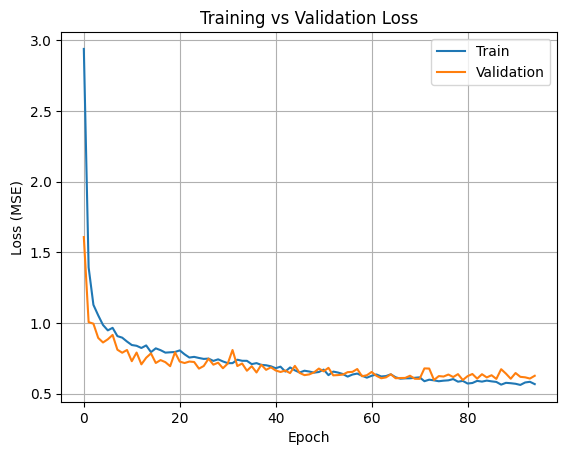

In [20]:
#Training vs Validation Loss per Epoch
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


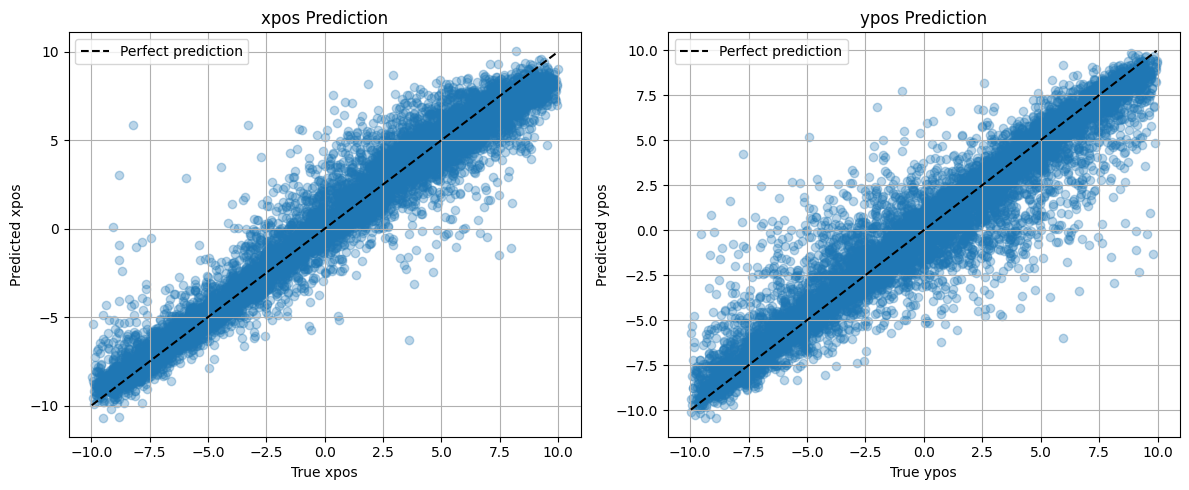

In [21]:
# Scatter Plots: True vs Predicted (xpos and ypos)
# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)

        preds = model(data)

        all_preds.append(preds)
        all_labels.append(labels)

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Denormalize
all_preds_denorm = denormalize(all_preds, x_mean, x_std, y_mean, y_std).cpu().numpy()
all_labels_denorm = denormalize(all_labels, x_mean, x_std, y_mean, y_std).cpu().numpy()

# Plot for xpos
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(all_labels_denorm[:, 0], all_preds_denorm[:, 0], alpha=0.3)
plt.plot([all_labels_denorm[:, 0].min(), all_labels_denorm[:, 0].max()],
         [all_labels_denorm[:, 0].min(), all_labels_denorm[:, 0].max()],
         'k--', label="Perfect prediction")
plt.xlabel("True xpos")
plt.ylabel("Predicted xpos")
plt.title("xpos Prediction")
plt.legend()
plt.grid(True)

# Plot for ypos
plt.subplot(1, 2, 2)
plt.scatter(all_labels_denorm[:, 1], all_preds_denorm[:, 1], alpha=0.3)
plt.plot([all_labels_denorm[:, 1].min(), all_labels_denorm[:, 1].max()],
         [all_labels_denorm[:, 1].min(), all_labels_denorm[:, 1].max()],
         'k--', label="Perfect prediction")
plt.xlabel("True ypos")
plt.ylabel("Predicted ypos")
plt.title("ypos Prediction")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


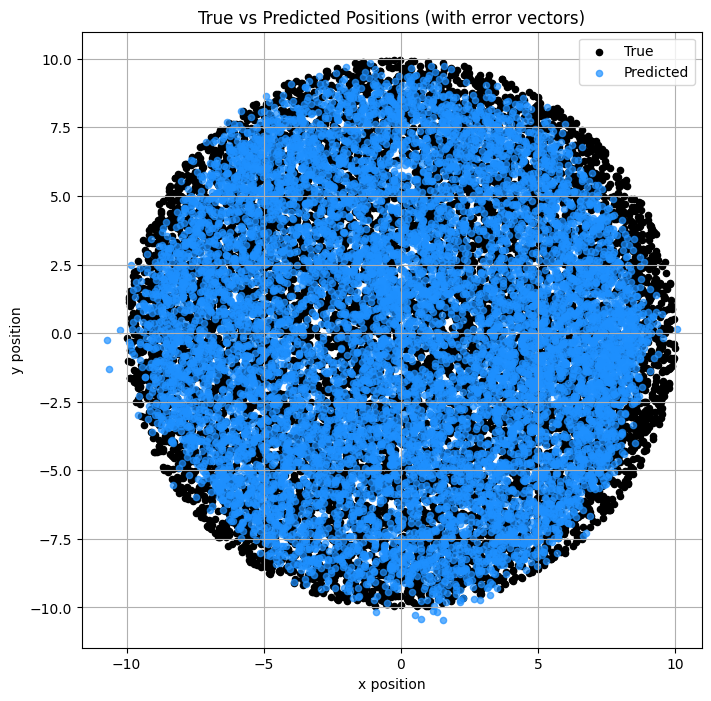

In [26]:
plt.figure(figsize=(8, 8))

# Arrow plot (error vectors)
"""plt.quiver(
    all_labels_denorm[:, 0], all_labels_denorm[:, 1],  # base = true
    all_preds_denorm[:, 0] - all_labels_denorm[:, 0],  # dx = pred - true
    all_preds_denorm[:, 1] - all_labels_denorm[:, 1],  # dy = pred - true
    angles='xy', scale_units='xy', scale=1, width=0.003, alpha=0.4, color='blue'
)"""

# Overlay actual positions
plt.scatter(all_labels_denorm[:, 0], all_labels_denorm[:, 1],
            label="True", c='black', s=20)
plt.scatter(all_preds_denorm[:, 0], all_preds_denorm[:, 1],
            label="Predicted", c='dodgerblue', s=20, alpha=0.7)

plt.xlabel("x position")
plt.ylabel("y position")
plt.title("True vs Predicted Positions (with error vectors)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [27]:
test_loss = evaluate(model, test_loader, loss_fn, device)
print(f"Final Test MSE (normalized units): {test_loss:.4f}")


Final Test MSE (normalized units): 0.5806


In [32]:
# Residuals
residuals = all_preds_denorm - all_labels_denorm  # shape [n_events, 2]
x_residuals = residuals[:, 0]
y_residuals = residuals[:, 1]

# Compute MSE
mse_x = mean_squared_error(all_labels_denorm[:, 0], all_preds_denorm[:, 0])
mse_y = mean_squared_error(all_labels_denorm[:, 1], all_preds_denorm[:, 1])

# Manually compute RMSE
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)

print(f"  RMSE (real units):")
print(f"  xpos: {rmse_x:.4f}")
print(f"  ypos: {rmse_y:.4f}")


  RMSE (real units):
  xpos: 1.2261
  ypos: 1.5665


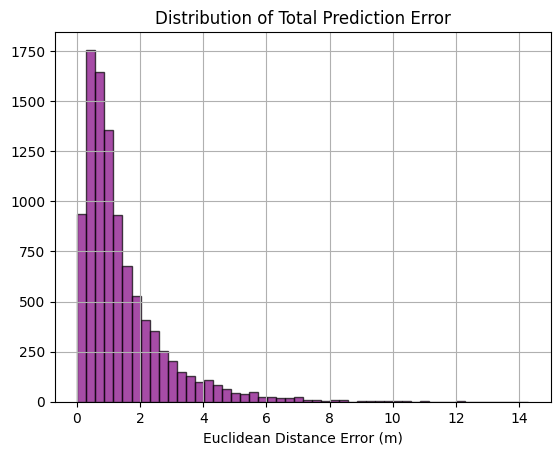

In [33]:
errors = np.linalg.norm(all_preds_denorm - all_labels_denorm, axis=1)
plt.hist(errors, bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel("Euclidean Distance Error (m)")
plt.title("Distribution of Total Prediction Error")
plt.grid(True)
plt.show()


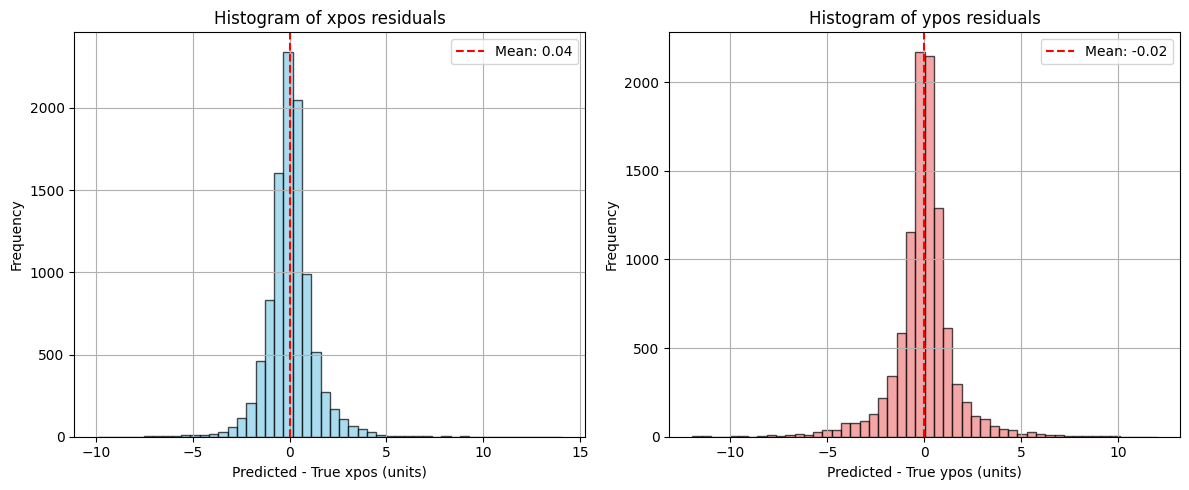

In [30]:
plt.figure(figsize=(12, 5))

# Histogram for xpos residuals
plt.subplot(1, 2, 1)
plt.hist(x_residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x_residuals.mean(), color='red', linestyle='dashed', label=f"Mean: {x_residuals.mean():.2f}")
plt.title("Histogram of xpos residuals")
plt.xlabel("Predicted - True xpos (units)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# Histogram for ypos residuals
plt.subplot(1, 2, 2)
plt.hist(y_residuals, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(y_residuals.mean(), color='red', linestyle='dashed', label=f"Mean: {y_residuals.mean():.2f}")
plt.title("Histogram of ypos residuals")
plt.xlabel("Predicted - True ypos (units)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
